In [1]:
import datetime as dt  
import pandas as pd
import numpy as np
from netCDF4 import Dataset 
import copy
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.mpl.ticker as cticker
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # colormap inside figure
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Path, PathPatch # for making ocean white
import cartopy.crs as ccrs
from ncdump import ncdump
import gdal,osr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
# user-defined
from scalebar import scale_bar
from VPRM_params import NLCD_def, bbox
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids,get_first_dimension_ave

FigDir = '/home/dwei/manuscripts/VPRM-sensitivity/fig/'

# Load NLCD and ISA
DataDir = '/data0/dwei/VPRMdata/'  # input dir
ds_nlcd = gdal.Open(DataDir+'nlcd_epsg32618_cropped.tif')
ds_ipsa = gdal.Open(DataDir+'ipsa_epsg32618_cropped.tif')
NLCD_2D = ds_nlcd.GetRasterBand(1).ReadAsArray()
IPSA_2D = ds_ipsa.GetRasterBand(1).ReadAsArray()
NLCD    = NLCD_2D.reshape(np.size(NLCD_2D))
IPSA    = IPSA_2D.reshape(np.size(IPSA_2D))
IPSA[IPSA==127] = 0.0  # 127 is the background value; assuming its zero
IPSA    = IPSA/100.0
# NLCD has zeros in the southeast corner; set them to 11 as water
NLCD[NLCD==0] = 11    
NLCD_2D[NLCD_2D==0] = 11  

# Load EVI and LSWI
#EVI_df  = pd.read_csv('/data0/dwei/Landsat/2021/EVI_all_intp_row2411760') 
EVI_raw = pd.read_csv('/data0/dwei/Landsat/2021/EVI_all_raw')
EVI     = EVI_raw.iloc[:,1:].to_numpy()  # First column is the row index
dt_EVI_str = ['20210107', '20210115', '20210123', \
          '20210208','20210224',\
          '20210304','20210312','20210320',\
          '20210405', '20210413', '20210421',\
          '20210507','20210515','20210523',\
          '20210608','20210616','20210624',\
          '20210710', '20210718','20210726',\
          '20210811','20210819','20210827', \
          '20210904','20210912', '20210920', '20210928',\
          '20211006', '20211014', '20211022', '20211030',\
          '20211107','20211115','20211123', \
          '20211201','20211209','20211217']
dt_EVI = [dt.datetime.strptime(x, '%Y%m%d') for x in dt_EVI_str]
index_growseason = []
for x in dt_EVI:
    if x > dt.datetime(2021, 6, 1, 0, 0) and x<dt.datetime(2021, 9, 1, 0, 0):
        index_growseason.append(dt_EVI.index(x))
#print(index_growseason)
EVI_m678 = np.nanmean(EVI[:, min(index_growseason):max(index_growseason)], axis=1)

# Read the center lat lon for the NYC-domain
df=pd.read_csv('/data0/dwei/VPRMout/NYC_domain_center_latlon')
#print(df.head())
center_lat = df.to_numpy()[:,1]
center_lon = df.to_numpy()[:,2]


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


In [2]:
# Data analysis for developed land in NYC (i.e. ISA and EVI)
def land_fraction(LandData, LandType):
    return np.size(LandData[LandData==LandType])/np.size(LandData)

def land_type_mean(LandData, LandType, Dataset):
    return np.nanmean(Dataset[LandData==LandType]),np.nanstd(Dataset[LandData==LandType])

# Set water to NaN
NLCD_flt = np.asarray(NLCD, dtype = np.float64)            
NLCD_land = NLCD[NLCD!=11.0]
IPSA_land = IPSA[NLCD!=11.0]
EVI_land = EVI_m678[NLCD!=11.0]

# Land type fractions
devo_frac = land_fraction(NLCD_land, 21)
devl_frac = land_fraction(NLCD_land, 22)
devm_frac = land_fraction(NLCD_land, 23)
devh_frac = land_fraction(NLCD_land, 24)
brl_frac = land_fraction(NLCD_land, 31)
ddf_frac = land_fraction(NLCD_land, 41)
egf_frac = land_fraction(NLCD_land, 42)
mxf_frac = land_fraction(NLCD_land, 43)
shb_frac = land_fraction(NLCD_land, 52)
grs_frac = land_fraction(NLCD_land, 71)
hay_frac = land_fraction(NLCD_land, 81)
crp_frac = land_fraction(NLCD_land, 82)
wt1_frac = land_fraction(NLCD_land, 90)
wt2_frac = land_fraction(NLCD_land, 95)
devt_frac  = devo_frac+devl_frac+devm_frac+devh_frac
vegt_frac = ddf_frac+egf_frac+mxf_frac+shb_frac+grs_frac+\
           hay_frac+crp_frac+wt1_frac+wt2_frac
# print('--------Developed land fraction  is %f--------' %devt_frac)
# print('--------Vegetated land fraction  is %f--------' %vegt_frac)
print('--------Open space fraction      is %f--------' %devo_frac)
# print('--------Low intensity fraction   is %f--------' %devl_frac)
# print('--------Mediu intensity fraction is %f--------' %devm_frac)
# print('--------High intensity fraction  is %f--------' %devh_frac)
print('--------Barren land fraction is %f--------' %brl_frac)

# IPSA averages
devo_ipsa,devo_ipsa_std = land_type_mean(NLCD_land, 21, IPSA_land)
devl_ipsa,devl_ipsa_std = land_type_mean(NLCD_land, 22, IPSA_land)
devm_ipsa,devm_ipsa_std = land_type_mean(NLCD_land, 23, IPSA_land)
devh_ipsa,devh_ipsa_std = land_type_mean(NLCD_land, 24, IPSA_land)
brl_ipsa,brl_ipsa_std = land_type_mean(NLCD_land, 31, IPSA_land)
ddf_ipsa,ddf_ipsa_std = land_type_mean(NLCD_land, 41, IPSA_land)
shb_ipsa,shb_ipsa_std = land_type_mean(NLCD_land, 52, IPSA_land)
grs_ipsa,grs_ipsa_std = land_type_mean(NLCD_land, 71, IPSA_land)
dev_ipsa_ave = (devo_ipsa+devl_ipsa+devm_ipsa+devh_ipsa)/4.0
print('--------Developed ISA       is %f--------' %dev_ipsa_ave)
print('--------Open space ISA      is %f--------' %devo_ipsa)
print('--------Low Intensity ISA   is %f--------' %devl_ipsa)
print('--------Mediu Intensity ISA is %f--------' %devm_ipsa)
print('--------High Intensity ISA  is %f--------' %devh_ipsa)
print('--------Barren land ISA     is %f--------' %brl_ipsa)

# EVI averages
devo_evi,devo_evi_std = land_type_mean(NLCD_land, 21, EVI_land)
devl_evi,devl_evi_std = land_type_mean(NLCD_land, 22, EVI_land)
devm_evi,devm_evi_std = land_type_mean(NLCD_land, 23, EVI_land)
devh_evi,devh_evi_std = land_type_mean(NLCD_land, 24, EVI_land)
brl_evi,brl_evi_std = land_type_mean(NLCD_land, 31, EVI_land)
ddf_evi,ddf_evi_std = land_type_mean(NLCD_land, 41, EVI_land)
shb_evi,shb_evi_std = land_type_mean(NLCD_land, 52, EVI_land)
grs_evi,grs_evi_std = land_type_mean(NLCD_land, 71, EVI_land)
print('grs EVI %f' %grs_evi)
print('ddf EVI %f' %ddf_evi)
print('shb EVI %f' %shb_evi)
print('brl EVI %f' %brl_evi)


--------Open space fraction      is 0.081116--------
--------Barren land fraction is 0.006082--------
--------Developed ISA       is 0.506743--------
--------Open space ISA      is 0.089843--------
--------Low Intensity ISA   is 0.359248--------
--------Mediu Intensity ISA is 0.666156--------
--------High Intensity ISA  is 0.911727--------
--------Barren land ISA     is 0.000000--------
grs EVI 0.515500
ddf EVI 0.655941
shb EVI 0.566963
brl EVI 0.206666


In [3]:
# NLCD and IPSA plot parameters
masked_nlcd = copy.deepcopy(NLCD_2D)
masked_nlcd[NLCD_2D==24] = 22  # High
masked_nlcd[NLCD_2D==23] = 23  # medium
masked_nlcd[NLCD_2D==22] = 24  # low
masked_nlcd[NLCD_2D==21] = 26  # open space
masked_nlcd[NLCD_2D>30]  = 21  # vegetation
masked_nlcd = np.ma.array(masked_nlcd, mask=masked_nlcd==11) # mask water
masked_ipsa = np.ma.array(IPSA_2D, mask=NLCD_2D==11)         # mask water


<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/matplotlib/colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


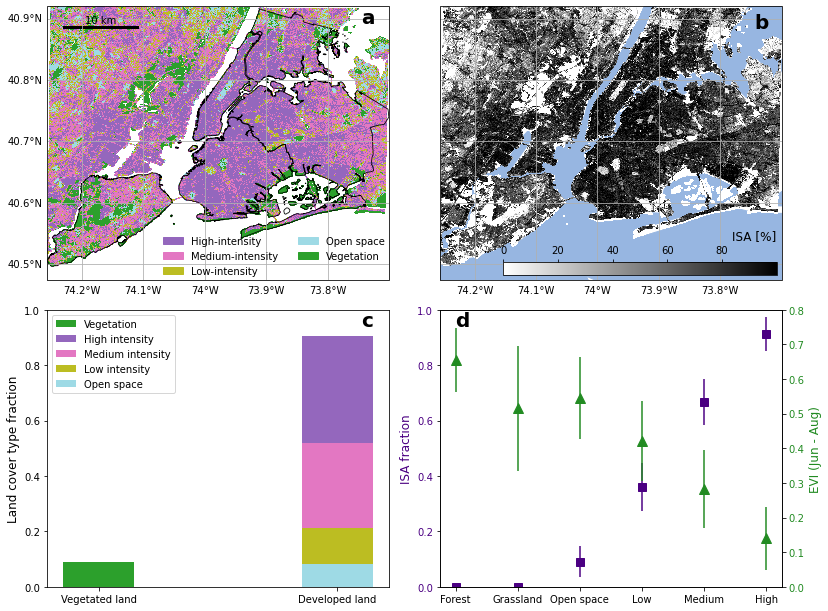

In [16]:
# Adding NYC borough boundaries
borough_bound = '/data0/dwei/NYC-borough-boundaries/geo_export_ef375cb0-7741-4888-a6d8-89441f79cdb5.shp'
reader = shpreader.Reader(borough_bound)
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# Plotting NLCD, ISA, EVI
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(4,2)
fig.subplots_adjust(hspace=-0.45, wspace=0.15, top=0.95, bottom=0.1, right=0.95, left=0.1)
FontSize=20
row = 2
col = 2
extent = [min(center_lon)-0.001, max(center_lon),min(center_lat)-0.02, max(center_lat)]

# Bar plot parameters
Width = 0.3
FontSize = 20
MarkerSize = 8
labels_nlcd = ['Vegetation','High-intensity', 'Medium-intensity', 'Low-intensity', 'Open space']
bar_labels = ['Developed land', 'Vegetated land']
labels = ['Forest', 'Grassland', 'Open space', 'Low', 'Medium', 'High']
ipsa_plots = [ddf_ipsa,grs_ipsa,devo_ipsa, devl_ipsa, devm_ipsa, devh_ipsa]
ipsa_err = [ddf_ipsa_std,grs_ipsa_std, devo_ipsa_std, devl_ipsa_std, devm_ipsa_std, devh_ipsa_std]
evi_plots = [ddf_evi, grs_evi, devo_evi, devl_evi, devm_evi, devh_evi]
evi_err = [ddf_evi_std, grs_evi_std, devo_evi_std, devl_evi_std, devm_evi_std, devh_evi_std] 

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 30-res NYC-VPRM on a map
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
legend_order = [1,2,3,4,0] #'High-intensity', 'Medium-intensity', 'Low-intensity', 'Open space','Vegetation'
ax1 = fig.add_subplot(gs[0:3,0], projection=ccrs.PlateCarree())
ax1.set_extent(extent, crs=ccrs.PlateCarree())
cc = ax1.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),masked_nlcd, 
               transform=ccrs.PlateCarree(),vmin=20, vmax = 25, cmap='tab20')
ax1.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.8) # Borough boundaries
scale_bar(ax1, (0.05, 0.03), 10, color='black') #scale bar of 10km 
# legend
values = np.unique(masked_nlcd.ravel())
colors = [cc.cmap(cc.norm(value)) for value in values] 
patches = [mpatches.Patch(color=colors[i], label=labels_nlcd[i]) for i in legend_order] #range(len(values)-1)]
ax1.legend(handles=patches, loc='lower right', borderaxespad=0.01, ncol=2,frameon=False)
# Axis labels
gl=ax1.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# IPSA map
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2 = fig.add_subplot(gs[0:3,1], projection=ccrs.PlateCarree())
ax2.set_extent(extent,crs=ccrs.PlateCarree())
cc = ax2.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),masked_ipsa, 
               transform=ccrs.PlateCarree(),vmin=0, vmax = 100, cmap='gist_yarg')
# Colorbar inside figure
axins1 = inset_axes(ax2,
                    width="80%",  # width = 50% of parent_bbox width
                    height="5%",  
                    loc='lower right')
cbar = plt.colorbar(cc, cax=axins1, orientation="horizontal", ticks=range(0,100,20))  
axins1.xaxis.set_ticks_position("top")
cbar.ax.set_title('ISA [%]', loc='right')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'))

# axis labels
gl=ax2.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels  = False
gl.left_labels = False
gl.right_labels= False

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# bar plot
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax3 = fig.add_subplot(gs[3,0])
ax3.bar(bar_labels[1], vegt_frac, width=Width, 
            label='Vegetation', color=colors[0])  # veg
ax3.bar(bar_labels[0], devh_frac, bottom = devo_frac+devl_frac+devm_frac, \
       width=Width,label='High intensity', color=colors[1])
ax3.bar(bar_labels[0], devm_frac, bottom = devl_frac+devo_frac, width=Width,label='Medium intensity', 
            color=colors[2])
ax3.bar(bar_labels[0], devl_frac, bottom = devo_frac, width=Width,
            label='Low intensity', color=colors[3])
ax3.bar(bar_labels[0], devo_frac, width=Width, 
            label='Open space', color=colors[4])
ax3.set_ylabel('Land cover type fraction', fontsize = FontSize-8)
ax3.set_ylim(0,1)
ax3.legend()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# ISA fractions
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4 = fig.add_subplot(gs[3,1])
ax4.errorbar(labels, ipsa_plots, yerr =ipsa_err, marker='s', color='indigo', 
                 linestyle='',markersize = MarkerSize)
ax4.set_ylim(0,1)
ax4.set_ylabel('ISA fraction', fontsize = FontSize-8, color='indigo')
ax4.tick_params(axis ='y', labelcolor = 'indigo')

ax5 = ax4.twinx() # Adding Twin Axes for EVI
ax5.errorbar(labels, evi_plots, yerr=evi_err ,marker='^', color='forestgreen',
             markersize = MarkerSize+2, linestyle='') 
ax5.set_ylabel('EVI (Jun - Aug)', fontsize = FontSize-8, color='forestgreen') 
ax5.tick_params(axis ='y', labelcolor = 'forestgreen')
ax5.set_ylim(0, 0.8)

#panels
txtx=0.92
txty=0.94
ax1.text(txtx, txty, 'a', transform=ax1.transAxes, fontsize = FontSize, fontweight='bold')
ax2.text(txtx, txty-0.02, 'b', transform=ax2.transAxes, fontsize = FontSize, fontweight='bold')
ax3.text(txtx, txty, 'c', transform=ax3.transAxes, fontsize = FontSize, fontweight='bold')
ax4.text(0.045, txty, 'd', transform=ax4.transAxes, fontsize = FontSize, fontweight='bold')

plt.show()
fig.savefig(FigDir+'fig1_developed_quantification.png')


0.0006943108979085728 0.0015355065991979736 0.0024026578480727417 0.0010388118022234467 0.000496694796974527
8.781528616581111


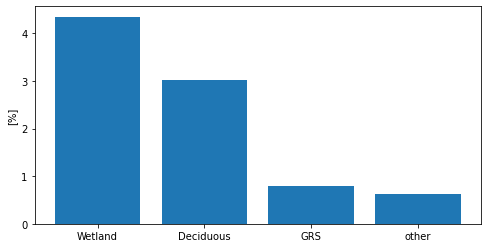

In [5]:
# The most abundant vegetation type in NYC
other_vegs = egf_frac+mxf_frac+shb_frac+hay_frac+crp_frac
wet_frac = wt1_frac+wt2_frac
veg_perc = np.asarray([wet_frac, ddf_frac, grs_frac,other_vegs])*100.0

fig = plt.figure(figsize=(8, 4))
plt.bar(['Wetland','Deciduous','GRS', 'other'], veg_perc)
plt.ylabel('[%]')

print(egf_frac,mxf_frac,shb_frac,hay_frac,crp_frac)
print(sum(veg_perc))

(37,)


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


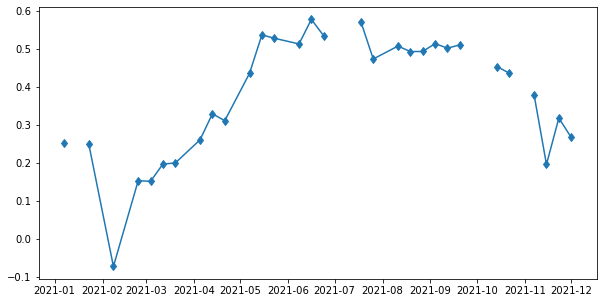

In [6]:
# annual cycle of EVI for different land cover
def land_type_mean(LandData, LandType, Dataset):
    return np.nanmean(Dataset[LandData==LandType, :],axis=1),np.nanstd(Dataset[LandData==LandType],axis=1)

evi_ave = np.nanmean(EVI[NLCD==21, :], axis=0)
print(np.shape(evi_ave))

fig=plt.figure(figsize=(10,5))
plt.plot(dt_EVI, evi_ave, marker='d')


The tiff file in Landsat projection already exists
(96876, 95800)
0
1
2
3
4
5
6
7
8
9280720800.0
9280720800
[22.406439376142657, 16.531653522136757, 1.7030477955777032, 20.190473459055735, 13.925785531331577, 24.490677189832617, 0.7519231259229504]
Tree canopy : 22.406439
Grass : 16.531654
Bare : 1.703048
Building : 20.190473
Roads : 13.925786
OtherISA : 24.490677
Railrods : 0.751923


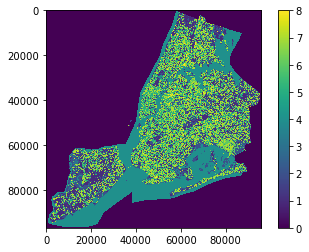

In [7]:
# Load the NYC 6 inch land map
NYC6in_legend = {'Tree canopy':1, 'Grass':2, 'Bare':3, 'water':4, 'Building':5,
                 'Roads':6, 'OtherISA':7, 'Railrods':8}
NYC6in_legend_nowater = {'Tree canopy':1, 'Grass':2, 'Bare':3, 'Building':5,
                'Roads':6, 'OtherISA':7, 'Railrods':8}
out_warped = '/data0/dwei/NYC-6inch/NYC_2017_6inch_32618.tif'

# Reproject the tif file to the Landsat projection (32618)
# Check if GTiff file exist
if os.path.exists(out_warped):
    print("The tiff file in Landsat projection already exists")
else:       
    ds_nyc  = gdal.Open(nyc_tif)
    warp_srs = osr.SpatialReference()
    warp_srs.ImportFromEPSG(32618)  
    warped_band =gdal.Warp(out_warped, ds_nyc, dstSRS=warp_srs,\
                   xRes = 0.5, yRes = 0.5,\
                   dstNodata=None)

# Read the two datasets
ds_nyc_lsat  = gdal.Open(out_warped)
NYC6in_2D_lsat = ds_nyc_lsat.GetRasterBand(1).ReadAsArray()
# print(np.shape(NYC6in_2D))
# print(np.shape(NYC6in_2D_lsat))
# print(ds_nyc.GetGeoTransform())
# print(ds_nyc_lsat.GetGeoTransform())

# Calculate the size of each land cover type from 0 to 9
print(np.shape(NYC6in_2D_lsat))
NYC6in_num = np.zeros(9)
for i in np.arange(0,9):
    print(i)
    NYC6in_num[i] = np.size(NYC6in_2D_lsat[NYC6in_2D_lsat==i])

print(sum(NYC6in_num))
print(96876*95800)

# Calculate the fraction of each land cover type from 1 to 9 without water
NYC6in_nonzero = NYC6in_num[1:]               # removes zeros
NYC6in_nonwater= np.delete(NYC6in_nonzero, 3) # removes water
NYC6in_fac = []
for x in NYC6in_nonwater:
    NYC6in_fac.append(x/sum(NYC6in_nonwater)*100.0)
print(NYC6in_fac)

# Display the non-water,non-zero fractions of each land cover type 
ind = 0
for key,val in NYC6in_legend_nowater.items():
    print('%s : %f' %(key,NYC6in_fac[ind]))
    ind+=1  
# Results from original NYC6inch
# Tree canopy : 22.406718
# Grass : 16.531506
# Bare : 1.703099
# Building : 20.190560
# Roads : 13.925733
# OtherISA : 24.490489
# Railrods : 0.751896

# Plot the NYC6inch_landsat_prj
[fig, ax] = plt.subplots(1, 1)
im = ax.imshow(NYC6in_2D_lsat, origin='upper', interpolation='none')
plt.colorbar(im)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


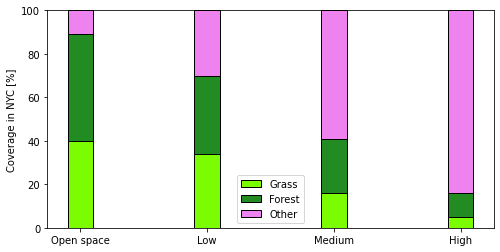

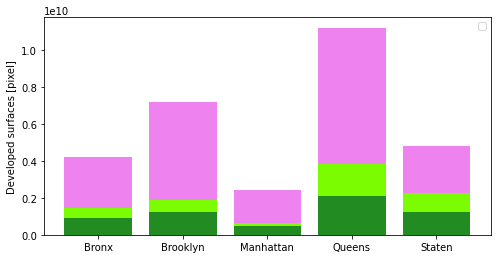

In [8]:
# NYC as a whole
GRS=np.array([40, 34, 16, 5])
FOR=np.array([49, 36, 25, 11])
ISA=100-GRS-FOR

fig,ax=plt.subplots(1, figsize=(8,4))
barWidth = 0.2
labels= ['Open space', 'Low', 'Medium', 'High']
ax.bar(labels,GRS, color ='lawngreen', width = barWidth,
        edgecolor ='k', label ='Grass')
ax.bar(labels, FOR, color ='forestgreen', width = barWidth,bottom=GRS,
        edgecolor ='k', label ='Forest')
ax.bar(labels, ISA, color ='violet', width = barWidth,bottom=GRS+FOR,
        edgecolor ='k', label ='Other')

ax.set_ylim(0,100)
ax.set_ylabel('Coverage in NYC [%]')
ax.legend()

# Each borough
Bronx_pixel_num = [382350440, 425161055, 1244273955, 2183224851]
Brook_pixel_num = [184228987,359291399,1493343341,5131818514]
Man_pixel_num = [152600951,145384754,468115662,1671069637]
Queen_pixel_num=[418086798,1077371050,3969877731,5736472717]
Staten_pixel_num=[505747750,847786979,2411999444,1032312292]

FOR_bronx = [194583175, 164905137, 307013947, 228795944]
GRS_bronx = [144981199, 131202587, 176763841, 111271023]

FOR_brook = [68378682, 121618996, 414091463,652069702]
GRS_brook = [99433320, 152222214, 169692790,182364117]

FOR_manha = [93443277,68573270,134352841,193716476]
GRS_manha = [33229342,29119379,38705571, 35184115]

FOR_queen = [188922547,351364123,955495755,585972718]
GRS_queen = [184168445,429729740,719337015,404259737]

FOR_state = [252306434,325735034,556979922,95223609]
GRS_state = [190195191,227822389,474712453,112428745]

FOR_sum=np.array([895298203,1256158843,490085864,2081755143,1230244999])
GRS_sum=np.array([564218650,603712441,136238407,1737494937,1005158778])
OTH_sum=np.array([2775493448,5308810957,1810846733,7382558216,2562442688])
DEV_num_by_borough = np.array([sum(Bronx_pixel_num),sum(Brook_pixel_num),
                               sum(Man_pixel_num),sum(Queen_pixel_num),
                              sum(Staten_pixel_num)])

fig,ax=plt.subplots(1, figsize=(8,4))
barWidth = 0.1
labels= ['Bronx','Brooklyn', 'Manhattan','Queens', 'Staten']
ax.bar(labels, FOR_sum, color ='forestgreen')
ax.bar(labels, GRS_sum, color ='lawngreen',bottom=FOR_sum)
ax.bar(labels, OTH_sum, color ='violet',bottom=FOR_sum+GRS_sum)
# ax.bar(labels, FOR, color ='forestgreen', width = barWidth,bottom=GRS,
#         edgecolor ='k', label ='Forest')
# ax.bar(labels, ISA, color ='violet', width = barWidth,bottom=GRS+FOR,
#         edgecolor ='k', label ='Other')
ax.set_ylabel('Developed surfaces [pixel]')
ax.legend()
